In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/home/aditya/Downloads/US_Accidents/US_Accidents_Dec20_3rd_copy.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
import warnings
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
import gc

init_notebook_mode(connected=True)

warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
data_file = '/home/aditya/Downloads/US_Accidents/US_Accidents_Dec20_3rd_copy.csv'
df = pd.read_csv(data_file)
train_df=df
df.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

# CLEANING DATA

In [4]:
df.drop(columns=['End_Lat', 'End_Lng' ,'Number', 'Airport_Code' ,'Weather_Timestamp' , 'TMC' , 
                 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
                 'Country','ID', 'Source','Timezone'], inplace=True)

In [5]:
from pprint import pprint
def sanity_check(df):
    pprint('-'*70)
    pprint('No. of Row : {0[0]}        No. of Columns : {0[1]}'.format(df.shape))
    pprint('-'*70)
    data_profile = pd.DataFrame(df.dtypes.reset_index()).rename(columns = {'index' : 'Attribute' ,
                                                                           0 : 'DataType'}).set_index('Attribute')
    data_profile = pd.concat([data_profile,df.isnull().sum()], axis=1).rename(columns = {0 : 'Missing Values'})
    data_profile = pd.concat([data_profile,df.nunique()], axis=1).rename(columns = {0 : 'Unique Values'})
    pprint(data_profile)
    pprint('-'*70)

In [6]:
df.dropna(subset=['City','Sunrise_Sunset','Description'], inplace=True)

In [7]:


df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])



In [8]:
sanity_check(df)

'----------------------------------------------------------------------'
'No. of Row : 999964        No. of Columns : 36'
'----------------------------------------------------------------------'
                         DataType  Missing Values  Unique Values
Severity                    int64               0              4
Start_Time         datetime64[ns]               0         975960
End_Time           datetime64[ns]               0         975940
Start_Lat                 float64               0         390345
Start_Lng                 float64               0         380003
Distance(mi)              float64               0           3029
Description                object               0         711244
Street                     object               0          85494
Side                       object               0              3
City                       object               0           8629
County                     object               0           1363
State                    

In [9]:
df.drop(columns=['Description','Street','City','County','Zipcode','Weather_Condition','Amenity','Bump','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Sunrise_Sunset','Turning_Loop','Give_Way','Wind_Direction','Crossing','Side'], inplace=True)

In [10]:
df['Start_Time'] = df['Start_Time'].astype(str).str[0:10]
df['End_Time'] = df['End_Time'].astype(str).str[0:10]
pd.set_option('display.max_columns', None)
df.head(5)

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),State,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
0,3,2016-02-08,2016-02-08,39.865147,-84.058723,0.01,OH,36.9,NaN,91.0,29.68,10.0,NaN,0.02
1,2,2016-02-08,2016-02-08,39.928059,-82.831184,0.01,OH,37.9,NaN,100.0,29.65,10.0,NaN,0.00
2,2,2016-02-08,2016-02-08,39.063148,-84.032608,0.01,OH,36.0,33.3,100.0,29.67,10.0,3.5,NaN
3,3,2016-02-08,2016-02-08,39.747753,-84.205582,0.01,OH,35.1,31.0,96.0,29.64,9.0,4.6,NaN
4,2,2016-02-08,2016-02-08,39.627781,-84.188354,0.01,OH,36.0,33.3,89.0,29.65,6.0,3.5,NaN


In [11]:
df1=df.groupby(by=["Start_Time","State"]).mean()
df1.head(5)

,,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
Start_Time,State,,,,,,,,,,,
2016-02-08,OH,2.277778,39.841393,-83.700875,0.073611,35.983333,31.493103,92.777778,29.637222,7.333333,5.530303,0.014118
2016-02-09,OH,2.428571,39.888841,-83.648646,0.009143,23.188571,12.288571,87.485714,29.677714,2.494286,11.125714,0.003846
2016-02-10,OH,2.562500,40.016197,-83.116289,0.086875,16.387500,3.687500,80.000000,29.918125,3.393750,11.300000,0.001000
2016-02-11,OH,2.314286,40.045109,-83.477221,0.021714,14.682857,4.575862,67.628571,30.260857,9.485714,8.510345,0.000000
2016-02-12,OH,2.714286,39.952918,-83.316945,0.908571,21.285714,6.628571,68.142857,30.120000,7.142857,18.585714,0.000000


In [12]:
df11=df.groupby(by=["State"]).mean()
df11.head(5)

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
State,,,,,,,,,,,
AL,2.265405,33.110256,-86.716402,0.370956,65.865823,65.336902,70.519483,29.602524,9.031099,6.408085,0.012884
AR,2.415902,35.329562,-92.077487,1.103364,58.003145,57.035032,81.496835,29.626656,8.927673,6.678344,0.007938
AZ,2.161568,33.186254,-111.755538,0.181148,71.678975,71.265416,31.779931,28.086619,9.875275,6.602433,0.000824
CA,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394
CO,2.460080,39.578850,-104.989835,0.507225,47.863813,44.608217,50.102612,24.193780,10.023356,7.922365,0.000951


# TRAIN DATA

In [13]:
train_df["Accident_count"]=1
train_df['Start_Time'] = train_df['Start_Time'].astype(str).str[0:10]
train_df1=train_df[['State','Start_Time', 'Accident_count']]
train_df1.head(5)

,State,Start_Time,Accident_count
0,OH,2016-02-08,1
1,OH,2016-02-08,1
2,OH,2016-02-08,1
3,OH,2016-02-08,1
4,OH,2016-02-08,1


In [14]:
train_df2=train_df1.groupby(by=['Start_Time','State']).sum()
train_df2.head(5)

,,Accident_count
Start_Time,State,
2016-02-08,OH,36
2016-02-09,OH,35
2016-02-10,OH,16
2016-02-11,OH,35
2016-02-12,OH,7


In [15]:
train_df3 = pd.merge(train_df2,df1,how='left', left_on=['Start_Time','State'], right_on = ['Start_Time','State'])
train_df3.head(5)

,,Accident_count,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
Start_Time,State,,,,,,,,,,,,
2016-02-08,OH,36,2.277778,39.841393,-83.700875,0.073611,35.983333,31.493103,92.777778,29.637222,7.333333,5.530303,0.014118
2016-02-09,OH,35,2.428571,39.888841,-83.648646,0.009143,23.188571,12.288571,87.485714,29.677714,2.494286,11.125714,0.003846
2016-02-10,OH,16,2.562500,40.016197,-83.116289,0.086875,16.387500,3.687500,80.000000,29.918125,3.393750,11.300000,0.001000
2016-02-11,OH,35,2.314286,40.045109,-83.477221,0.021714,14.682857,4.575862,67.628571,30.260857,9.485714,8.510345,0.000000
2016-02-12,OH,7,2.714286,39.952918,-83.316945,0.908571,21.285714,6.628571,68.142857,30.120000,7.142857,18.585714,0.000000


In [16]:
train_df3=train_df3.rename(columns={"Distance(mi)": "Distance"})
train_df3=train_df3.rename(columns={"Temperature(F)": "Temperature"})
train_df3=train_df3.rename(columns={"Wind_Chill(F)": "Wind_Chill"})
train_df3=train_df3.rename(columns={"Humidity(%)": "Humidity"})
train_df3=train_df3.rename(columns={"Pressure(in)": "Pressure"})
train_df3=train_df3.rename(columns={"Visibility(mi)": "Visibility"})
train_df3=train_df3.rename(columns={"Wind_Speed(mph)": "Wind_Speed"})
train_df3=train_df3.rename(columns={"Precipitation(in)": "Precipitation"})
train_df3.head(5)

,,Accident_count,Severity,Start_Lat,Start_Lng,Distance,Temperature,Wind_Chill,Humidity,Pressure,Visibility,Wind_Speed,Precipitation
Start_Time,State,,,,,,,,,,,,
2016-02-08,OH,36,2.277778,39.841393,-83.700875,0.073611,35.983333,31.493103,92.777778,29.637222,7.333333,5.530303,0.014118
2016-02-09,OH,35,2.428571,39.888841,-83.648646,0.009143,23.188571,12.288571,87.485714,29.677714,2.494286,11.125714,0.003846
2016-02-10,OH,16,2.562500,40.016197,-83.116289,0.086875,16.387500,3.687500,80.000000,29.918125,3.393750,11.300000,0.001000
2016-02-11,OH,35,2.314286,40.045109,-83.477221,0.021714,14.682857,4.575862,67.628571,30.260857,9.485714,8.510345,0.000000
2016-02-12,OH,7,2.714286,39.952918,-83.316945,0.908571,21.285714,6.628571,68.142857,30.120000,7.142857,18.585714,0.000000


In [17]:
train_df3.reset_index(level=0, inplace=True)
train_df3.head(5)

,Start_Time,Accident_count,Severity,Start_Lat,Start_Lng,Distance,Temperature,Wind_Chill,Humidity,Pressure,Visibility,Wind_Speed,Precipitation
State,,,,,,,,,,,,,
OH,2016-02-08,36,2.277778,39.841393,-83.700875,0.073611,35.983333,31.493103,92.777778,29.637222,7.333333,5.530303,0.014118
OH,2016-02-09,35,2.428571,39.888841,-83.648646,0.009143,23.188571,12.288571,87.485714,29.677714,2.494286,11.125714,0.003846
OH,2016-02-10,16,2.562500,40.016197,-83.116289,0.086875,16.387500,3.687500,80.000000,29.918125,3.393750,11.300000,0.001000
OH,2016-02-11,35,2.314286,40.045109,-83.477221,0.021714,14.682857,4.575862,67.628571,30.260857,9.485714,8.510345,0.000000
OH,2016-02-12,7,2.714286,39.952918,-83.316945,0.908571,21.285714,6.628571,68.142857,30.120000,7.142857,18.585714,0.000000


In [18]:
train_df3['year']=train_df3['Start_Time'].astype(str).str[0:4]
train_df3['month']=train_df3['Start_Time'].astype(str).str[5:7]
train_df3['day']=train_df3['Start_Time'].astype(str).str[8:10]
train_df3.head(5)

,Start_Time,Accident_count,Severity,Start_Lat,Start_Lng,Distance,Temperature,Wind_Chill,Humidity,Pressure,Visibility,Wind_Speed,Precipitation,year,month,day
State,,,,,,,,,,,,,,,,
OH,2016-02-08,36,2.277778,39.841393,-83.700875,0.073611,35.983333,31.493103,92.777778,29.637222,7.333333,5.530303,0.014118,2016,02,08
OH,2016-02-09,35,2.428571,39.888841,-83.648646,0.009143,23.188571,12.288571,87.485714,29.677714,2.494286,11.125714,0.003846,2016,02,09
OH,2016-02-10,16,2.562500,40.016197,-83.116289,0.086875,16.387500,3.687500,80.000000,29.918125,3.393750,11.300000,0.001000,2016,02,10
OH,2016-02-11,35,2.314286,40.045109,-83.477221,0.021714,14.682857,4.575862,67.628571,30.260857,9.485714,8.510345,0.000000,2016,02,11
OH,2016-02-12,7,2.714286,39.952918,-83.316945,0.908571,21.285714,6.628571,68.142857,30.120000,7.142857,18.585714,0.000000,2016,02,12


In [19]:
train_df3.reset_index(level=0, inplace=True)
train_df3.head(5)

,State,Start_Time,Accident_count,Severity,Start_Lat,Start_Lng,Distance,Temperature,Wind_Chill,Humidity,Pressure,Visibility,Wind_Speed,Precipitation,year,month,day
0,OH,2016-02-08,36,2.277778,39.841393,-83.700875,0.073611,35.983333,31.493103,92.777778,29.637222,7.333333,5.530303,0.014118,2016,02,08
1,OH,2016-02-09,35,2.428571,39.888841,-83.648646,0.009143,23.188571,12.288571,87.485714,29.677714,2.494286,11.125714,0.003846,2016,02,09
2,OH,2016-02-10,16,2.562500,40.016197,-83.116289,0.086875,16.387500,3.687500,80.000000,29.918125,3.393750,11.300000,0.001000,2016,02,10
3,OH,2016-02-11,35,2.314286,40.045109,-83.477221,0.021714,14.682857,4.575862,67.628571,30.260857,9.485714,8.510345,0.000000,2016,02,11
4,OH,2016-02-12,7,2.714286,39.952918,-83.316945,0.908571,21.285714,6.628571,68.142857,30.120000,7.142857,18.585714,0.000000,2016,02,12


In [20]:
train_df3=train_df3.dropna()
train=train_df3

In [21]:
data_file1 = '/home/aditya/Downloads/US_Accidents/test.csv'
test_df = pd.read_csv(data_file1)
testt_df = pd.read_csv(data_file1)
test_df.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

# TEST DATA

In [22]:
test_df["Accident_count"]=0
test_df['Start_Time'] = test_df['Start_Time'].astype(str).str[0:10]
test_df1=test_df[['State','Start_Time', 'Accident_count']]
test_df1.head(5)

,State,Start_Time,Accident_count
0,NC,2019-12-05,0
1,NC,2019-12-05,0
2,NC,2019-12-05,0
3,VA,2019-12-05,0
4,VA,2019-12-05,0


In [23]:
test_df2=test_df1.groupby(by=['Start_Time','State']).sum()
test_df2.head(5)

Accident_count
Start_Time State                
2019-12-04 CA                  0
           WA                  0
2019-12-05 AL                  0
           AZ                  0
           CA                  0

In [24]:
test_df3 = pd.merge(test_df2,df11,how='left', left_on=['State'], right_on = ['State'])
test_df3.head(5)

,Accident_count,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
State,,,,,,,,,,,,
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394
WA,0,2.386990,47.524463,-121.938787,0.139180,54.278694,46.565097,72.663637,29.890347,9.121186,7.225568,0.009887
AL,0,2.265405,33.110256,-86.716402,0.370956,65.865823,65.336902,70.519483,29.602524,9.031099,6.408085,0.012884
AZ,0,2.161568,33.186254,-111.755538,0.181148,71.678975,71.265416,31.779931,28.086619,9.875275,6.602433,0.000824
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394


In [25]:
test_df3=test_df3.rename(columns={"Distance(mi)": "Distance"})
test_df3=test_df3.rename(columns={"Temperature(F)": "Temperature"})
test_df3=test_df3.rename(columns={"Wind_Chill(F)": "Wind_Chill"})
test_df3=test_df3.rename(columns={"Humidity(%)": "Humidity"})
test_df3=test_df3.rename(columns={"Pressure(in)": "Pressure"})
test_df3=test_df3.rename(columns={"Visibility(mi)": "Visibility"})
test_df3=test_df3.rename(columns={"Wind_Speed(mph)": "Wind_Speed"})
test_df3=test_df3.rename(columns={"Precipitation(in)": "Precipitation"})
test_df3.head(5)

,Accident_count,Severity,Start_Lat,Start_Lng,Distance,Temperature,Wind_Chill,Humidity,Pressure,Visibility,Wind_Speed,Precipitation
State,,,,,,,,,,,,
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394
WA,0,2.386990,47.524463,-121.938787,0.139180,54.278694,46.565097,72.663637,29.890347,9.121186,7.225568,0.009887
AL,0,2.265405,33.110256,-86.716402,0.370956,65.865823,65.336902,70.519483,29.602524,9.031099,6.408085,0.012884
AZ,0,2.161568,33.186254,-111.755538,0.181148,71.678975,71.265416,31.779931,28.086619,9.875275,6.602433,0.000824
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394


In [26]:
test_df2.reset_index(level=0, inplace=True)
test_df2.head(5)

,Start_Time,Accident_count
State,,
CA,2019-12-04,0
WA,2019-12-04,0
AL,2019-12-05,0
AZ,2019-12-05,0
CA,2019-12-05,0


In [27]:
test_df4 = pd.merge(test_df3,test_df2,how='left', left_on=['State'], right_on = ['State'])
test_df4.head(5)

,Accident_count_x,Severity,Start_Lat,Start_Lng,Distance,Temperature,Wind_Chill,Humidity,Pressure,Visibility,Wind_Speed,Precipitation,Start_Time,Accident_count_y
State,,,,,,,,,,,,,,
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-04,0
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-05,0
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-06,0
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-07,0
WA,0,2.386990,47.524463,-121.938787,0.139180,54.278694,46.565097,72.663637,29.890347,9.121186,7.225568,0.009887,2019-12-04,0


In [28]:
test_df5=test_df4.drop(columns={"Accident_count_y"})
test_df5=test_df5.rename(columns={"Accident_count_x": "Accident_count"})
test_df5.head(5)

,Accident_count,Severity,Start_Lat,Start_Lng,Distance,Temperature,Wind_Chill,Humidity,Pressure,Visibility,Wind_Speed,Precipitation,Start_Time
State,,,,,,,,,,,,,
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-04
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-05
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-06
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-07
WA,0,2.386990,47.524463,-121.938787,0.139180,54.278694,46.565097,72.663637,29.890347,9.121186,7.225568,0.009887,2019-12-04


In [29]:
test_df5['year']=test_df5['Start_Time'].astype(str).str[0:4]
test_df5['month']=test_df5['Start_Time'].astype(str).str[5:7]
test_df5['day']=test_df5['Start_Time'].astype(str).str[8:10]
test_df5.head(5)

,Accident_count,Severity,Start_Lat,Start_Lng,Distance,Temperature,Wind_Chill,Humidity,Pressure,Visibility,Wind_Speed,Precipitation,Start_Time,year,month,day
State,,,,,,,,,,,,,,,,
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-04,2019,12,04
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-05,2019,12,05
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-06,2019,12,06
CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-07,2019,12,07
WA,0,2.386990,47.524463,-121.938787,0.139180,54.278694,46.565097,72.663637,29.890347,9.121186,7.225568,0.009887,2019-12-04,2019,12,04


In [30]:
test_df5.reset_index(level=0, inplace=True)
test_df5.head(5)

,State,Accident_count,Severity,Start_Lat,Start_Lng,Distance,Temperature,Wind_Chill,Humidity,Pressure,Visibility,Wind_Speed,Precipitation,Start_Time,year,month,day
0,CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-04,2019,12,04
1,CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-05,2019,12,05
2,CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-06,2019,12,06
3,CA,0,2.409038,35.512295,-119.489971,0.040106,65.681305,62.799356,59.940059,29.847758,9.190683,7.193729,0.006394,2019-12-07,2019,12,07
4,WA,0,2.386990,47.524463,-121.938787,0.139180,54.278694,46.565097,72.663637,29.890347,9.121186,7.225568,0.009887,2019-12-04,2019,12,04


In [31]:
test_df5=test_df5.dropna()
test=test_df5

In [32]:
print('Binding to float32')

for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

train_x = train.drop(['State', 'Start_Time', 'Accident_count'], axis=1)
train_y = np.log1p(train['Accident_count'].values)
print(train_x.shape, train_y.shape)
test_x = test.drop(['State', 'Start_Time', 'Accident_count'], axis=1)


Binding to float32
(16473, 14) (16473,)


In [33]:
train_x.head()

,Severity,Start_Lat,Start_Lng,Distance,Temperature,Wind_Chill,Humidity,Pressure,Visibility,Wind_Speed,Precipitation,year,month,day
0,2.277778,39.841393,-83.700874,0.073611,35.983334,31.493103,92.777779,29.637222,7.333333,5.530303,0.014118,2016,02,08
1,2.428571,39.888840,-83.648643,0.009143,23.188572,12.288571,87.485718,29.677713,2.494286,11.125714,0.003846,2016,02,09
2,2.562500,40.016197,-83.116287,0.086875,16.387501,3.687500,80.000000,29.918125,3.393750,11.300000,0.001000,2016,02,10
3,2.314286,40.045109,-83.477219,0.021714,14.682858,4.575862,67.628571,30.260857,9.485714,8.510345,0.000000,2016,02,11
4,2.714286,39.952919,-83.316948,0.908571,21.285715,6.628572,68.142860,30.120001,7.142857,18.585714,0.000000,2016,02,12


In [34]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16473 entries, 0 to 22910
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Severity       16473 non-null  float32
 1   Start_Lat      16473 non-null  float32
 2   Start_Lng      16473 non-null  float32
 3   Distance       16473 non-null  float32
 4   Temperature    16473 non-null  float32
 5   Wind_Chill     16473 non-null  float32
 6   Humidity       16473 non-null  float32
 7   Pressure       16473 non-null  float32
 8   Visibility     16473 non-null  float32
 9   Wind_Speed     16473 non-null  float32
 10  Precipitation  16473 non-null  float32
 11  year           16473 non-null  object 
 12  month          16473 non-null  object 
 13  day            16473 non-null  object 
dtypes: float32(11), object(3)
memory usage: 1.2+ MB


In [35]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Severity       300 non-null    float32
 1   Start_Lat      300 non-null    float32
 2   Start_Lng      300 non-null    float32
 3   Distance       300 non-null    float32
 4   Temperature    300 non-null    float32
 5   Wind_Chill     300 non-null    float32
 6   Humidity       300 non-null    float32
 7   Pressure       300 non-null    float32
 8   Visibility     300 non-null    float32
 9   Wind_Speed     300 non-null    float32
 10  Precipitation  300 non-null    float32
 11  year           300 non-null    object 
 12  month          300 non-null    object 
 13  day            300 non-null    object 
dtypes: float32(11), object(3)
memory usage: 22.3+ KB


In [36]:
train_y

array([3.61091791, 3.58351894, 2.83321334, ..., 1.38629436, 2.77258872,
       1.60943791])

# Random Forest Regression Model

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
print('Binding to float32')

for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

train_x = train.drop(['State', 'Start_Time', 'Accident_count'], axis=1)
train_y = np.log1p(train['Accident_count'].values)
print(train_x.shape, train_y.shape)
test_x = test.drop(['State', 'Start_Time', 'Accident_count'], axis=1)

Binding to float32
(16473, 14) (16473,)


In [39]:
rf = RandomForestRegressor(max_depth = 45, n_estimators = 60, n_jobs=-1)
rf.fit(train_x,train_y)

RandomForestRegressor(max_depth=45, n_estimators=60, n_jobs=-1)

In [40]:
rf.score(train_x, train_y)

0.9841572859628099

In [41]:
predict_y = rf.predict(test_x)

In [42]:
test['Accident_count'] = np.expm1(predict_y)

In [43]:
test[['State','Start_Time', 'Accident_count']].to_csv('rf.csv', index=False, float_format=None)

In [44]:
rf_submission2 = pd.read_csv("rf.csv")
rf_submission2.head(10)

,State,Start_Time,Accident_count
0,CA,2019-12-04,188.985474
1,CA,2019-12-05,187.477824
2,CA,2019-12-06,187.830347
3,CA,2019-12-07,188.211023
4,WA,2019-12-04,26.725075
5,WA,2019-12-05,26.616058
6,WA,2019-12-06,26.616058
7,WA,2019-12-07,26.616058
8,AL,2019-12-05,46.817725
9,AL,2019-12-06,46.909873


# Decision Tree Regression Model

In [45]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

In [46]:
dt = DecisionTreeRegressor(max_depth = 5, min_samples_split = 10)
dt.fit(train_x,train_y)

DecisionTreeRegressor(max_depth=5, min_samples_split=10)

In [47]:
dt.score(train_x, train_y)

0.6944878305191196

In [48]:
predict_y1 = dt.predict(test_x)

In [49]:
test['Accident_count'] = np.expm1(predict_y1)

In [50]:
test[['State','Start_Time', 'Accident_count']].to_csv('dt.csv', index=False, float_format=None)

In [51]:
dt_submission = pd.read_csv("dt.csv")
dt_submission.head(10)

,State,Start_Time,Accident_count
0,CA,2019-12-04,203.923466
1,CA,2019-12-05,203.923466
2,CA,2019-12-06,203.923466
3,CA,2019-12-07,203.923466
4,WA,2019-12-04,28.416331
5,WA,2019-12-05,28.416331
6,WA,2019-12-06,28.416331
7,WA,2019-12-07,28.416331
8,AL,2019-12-05,72.327019
9,AL,2019-12-06,72.327019


# RESULTS

In [61]:
result = pd.merge(rf_submission2, dt_submission,how='left', left_on=['State','Start_Time'], right_on = ['State','Start_Time'])
result.head(5)

,State,Start_Time,Accident_count_x,Accident_count_y
0,CA,2019-12-04,188.985474,203.923466
1,CA,2019-12-04,188.985474,203.923466
2,CA,2019-12-04,188.985474,203.923466
3,CA,2019-12-04,188.985474,203.923466
4,CA,2019-12-05,187.477824,203.923466


# ACTUAL TEST DATA COUNT

In [53]:
testt_df["Accident_count"]=1
testt_df['Start_Time'] = testt_df['Start_Time'].astype(str).str[0:10]
testt_df=testt_df[['State','Start_Time', 'Accident_count']]
testt_df.head(5)

,State,Start_Time,Accident_count
0,NC,2019-12-05,1
1,NC,2019-12-05,1
2,NC,2019-12-05,1
3,VA,2019-12-05,1
4,VA,2019-12-05,1


In [54]:
testt_df=testt_df.groupby(by=['Start_Time','State']).sum()
testt_df.head(5)

Accident_count
Start_Time State                
2019-12-04 CA                 21
           WA                 10
2019-12-05 AL                 67
           AZ                 69
           CA                276

In [55]:
testt_df.reset_index(level=0, inplace=True)
testt_df.head(5)

,Start_Time,Accident_count
State,,
CA,2019-12-04,21
WA,2019-12-04,10
AL,2019-12-05,67
AZ,2019-12-05,69
CA,2019-12-05,276


In [56]:
testt_df.reset_index(level=0, inplace=True)
testt_df.head(5)

,State,Start_Time,Accident_count
0,CA,2019-12-04,21
1,WA,2019-12-04,10
2,AL,2019-12-05,67
3,AZ,2019-12-05,69
4,CA,2019-12-05,276


# RESULT

In [57]:
result1 = pd.merge(result,testt_df,how='left', left_on=['State','Start_Time'], right_on = ['State','Start_Time'])
result1.head(5)

,State,Start_Time,Accident_count_x,Accident_count_y,Accident_count
0,CA,2019-12-04,203.923466,188.985474,21
1,CA,2019-12-04,203.923466,188.985474,21
2,CA,2019-12-04,203.923466,188.985474,21
3,CA,2019-12-04,203.923466,188.985474,21
4,CA,2019-12-05,203.923466,187.477824,276


In [75]:

testt_df[(testt_df.State == "CA") & ((testt_df.Start_Time == "2019-12-04")| (testt_df.Start_Time == "2019-12-05")|
                                     (testt_df.Start_Time == "2019-12-06")| (testt_df.Start_Time == "2019-12-07"))]

,State,Start_Time,Accident_count
0,CA,2019-12-04,21
4,CA,2019-12-05,276
31,CA,2019-12-06,273
72,CA,2019-12-07,34


In [72]:

testt_df[(testt_df.State == "WA") & ((testt_df.Start_Time == "2019-12-04")| (testt_df.Start_Time == "2019-12-05")|
                                     (testt_df.Start_Time == "2019-12-06")| (testt_df.Start_Time == "2019-12-07"))]

,State,Start_Time,Accident_count
1,WA,2019-12-04,10
26,WA,2019-12-05,24
68,WA,2019-12-06,30
104,WA,2019-12-07,25


In [74]:

testt_df[(testt_df.State == "AL") & ((testt_df.Start_Time == "2019-12-05")|
                                     (testt_df.Start_Time == "2019-12-06")| (testt_df.Start_Time == "2019-12-07"))]

,State,Start_Time,Accident_count
2,AL,2019-12-05,67
28,AL,2019-12-06,84
70,AL,2019-12-07,19


In [10]:
top_10_state = df[['City','State' , 'Severity']].groupby('State').agg({'City' : 'count' , 
                                                       'Severity' : 'mean' }).sort_values(
    by='City',ascending=False).head(10)

In [11]:
df_state_city = df[['State' , 'City','Severity']].groupby(['State' , 'City']).count().rename(columns = {'Severity' : 'Count'})

top_10_city = df_state_city.sort_values(by='Count' , ascending = False).head(10)

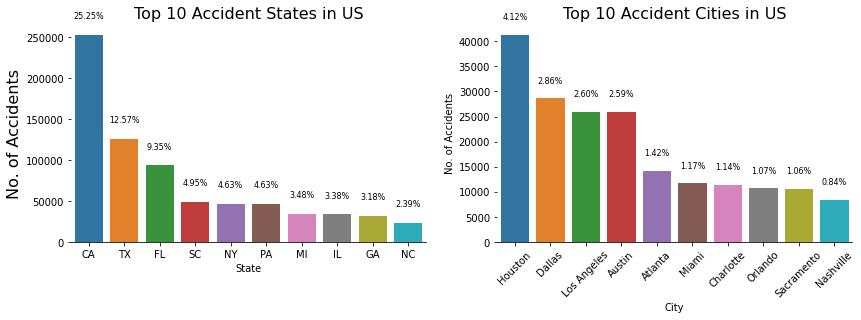

In [12]:
fig , (ax1, ax2) = plt.subplots(1,2,figsize=(14,4))

bar = sns.barplot(x=top_10_state.index , y=top_10_state['City'],
                  #palette='nipy_spectral_r' , 
#                   palette='pastel' , 
                  #edgecolor = 'black',
                  ax=ax1 )
sns.despine(left = True )
ax1.set_xlabel("State")
ax1.set_ylabel("No. of Accidents" , fontdict = {'fontsize':16 })
ax1.set_title('Top 10 Accident States in US', fontdict = {'fontsize':16 })
# ax3=ax1.twinx()
# ax3.plot(top_10_state['Severity'] ,'o-', color='lightgray')
# ax3.set_ylabel('Severity')


bar = sns.barplot(x=top_10_city.index.get_level_values(1) , y=top_10_city['Count'],
                  #palette='nipy_spectral' , 
#                   palette='pastel' , 
                  #edgecolor = 'black',
                  ax=ax2
                 )
sns.despine(left = True )
ax2.set_xlabel("City" )
ax2.set_ylabel("No. of Accidents")
ax2.set_title('Top 10 Accident Cities in US', fontdict = {'fontsize':16 })
plt.xticks(rotation = 45)


# Working to get labels for percentages
total_accidents = len(df)

# for state
for p in ax1.patches :
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width()/2,
            height + 20000,
            '{:.2f}%'.format(height/total_accidents*100),
            ha = "center",
            fontsize = 8)

    
# for City
for p in ax2.patches :
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width()/2,
            height + 3000,
            '{:.2f}%'.format(height/total_accidents*100),
            ha = "center",
            fontsize = 8)
    
    
fig.show()

In [13]:
# Creating Date Time series attributes


df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month  # .dt.month_name()
df['Hour'] = df['Start_Time'].dt.hour
diff = df['End_Time'] - df['Start_Time']
df['DelayTime'] = round(diff.dt.seconds/3600,1)
year = df['Year'].value_counts()
month = df['Month'].value_counts().sort_index()
month_map = {1:'Jan' , 2:'Feb' , 3:'Mar' , 4:'Apr' , 5:'May' , 6:'Jun', 7:'Jul' , 8:'Aug' 
             , 9:'Sep',10:'Oct' , 11:'Nov' , 12:'Dec'}

hour_severity = df[['Hour' , 'Severity']].groupby('Hour').agg({'Hour' : 'count' , 'Severity' : 'mean'})

df['Day'] = df['Start_Time'].dt.dayofweek
day_severity = df[['Day' , 'Severity']].groupby('Day').agg({'Day' : 'count' , 'Severity' : 'mean'})
day_map = {0:'Monday' , 1:'Tueday' , 2:'Wedday' , 3:"Thuday" , 4:'Friday' , 5:"Saturday" , 6:'Sunday'}


# df['Month'].head()


In [14]:
hour_severity = df[['Hour' , 'Severity']].groupby('Hour').agg({'Hour' : 'count' , 'Severity' : 'mean'})

df['Day'] = df['Start_Time'].dt.dayofweek
day_severity = df[['Day' , 'Severity']].groupby('Day').agg({'Day' : 'count' , 'Severity' : 'mean'})
day_map = {0:'Monday' , 1:'Tueday' , 2:'Wedday' , 3:"Thuday" , 4:'Friday' , 5:"Saturday" , 6:'Sunday'}

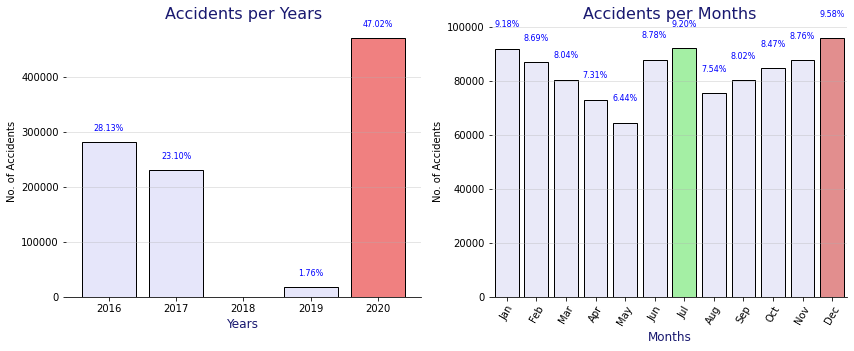

In [15]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))


# plot for year

light_palette = sns.color_palette(palette='pastel')

year_color_map = ['Lavender' for _ in range(5)]
year_color_map[0] = 'LightCoral' #light_palette[0]
year_color_map[4] = 'PaleGreen' #light_palette[2]

years = ax1.bar(year.index.values , year, color=year_color_map , edgecolor = 'black')
ax1.spines[('top')].set_visible(False)
ax1.spines[('right')].set_visible(False)
ax1.set_xlabel("Years", fontdict = {'fontsize':12 , 'color':'MidnightBlue'} )
ax1.set_ylabel("No. of Accidents")
ax1.set_title('Accidents per Years', fontdict = {'fontsize':16 , 'color':'MidnightBlue'})

for p in ax1.patches :
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width()/2,
            height + 20000,
            '{:.2f}%'.format(height/total_accidents*100),
            ha = "center",
            fontsize = 8, color='Blue')

    
# plot for month


month_color_map = ['Lavender' for _ in range(12)]
month_color_map[11] = 'LightCoral' #light_palette[0]
month_color_map[6] = 'PaleGreen' #light_palette[2]

m = sns.barplot( x= month.index.map(month_map), y=month,  ax = ax2, palette=month_color_map , edgecolor='black' )
plt.xticks(rotation=60)
ax2.set_xlabel("Months", fontdict = {'fontsize':12 , 'color':'MidnightBlue'} )
ax2.set_ylabel("No. of Accidents")
ax2.set_title('Accidents per Months', fontdict = {'fontsize':16 , 'color':'MidnightBlue'})
sns.despine(left=True)

for p in ax2.patches :
    height = p.get_height()
    ax2.text(p.get_x() + p.get_width()/2,
            height + 8000,
            '{:.2f}%'.format(height/total_accidents*100),
            ha = "center",
            fontsize = 8, color='blue')

ax1.grid(axis='y', linestyle='-', alpha=0.4)    
ax2.grid(axis='y', linestyle='-', alpha=0.4) 
    
plt.show()

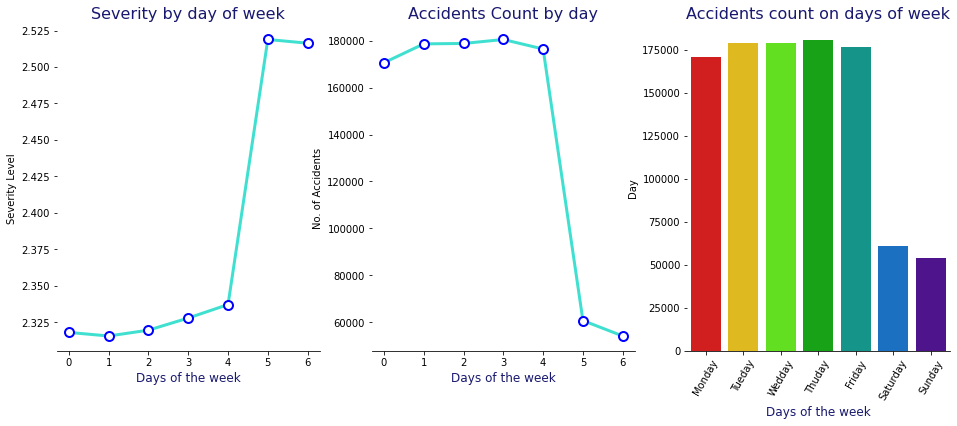

In [16]:
fig, (ax , ax2, ax3) = plt.subplots(1,3,figsize = (16,6))

sns.set_context('paper')

# f = sns.lineplot(x=day_severity['Day'].index.map(day_map) , y=day_severity['Severity'], 
#                  ax = ax,  label='Severity', legend = 'full' , dashes=True, palette=light_palette, color='red')


ax.plot(day_severity['Severity'] ,  color='Turquoise', label=day_map,linewidth=3,
           linestyle='solid',marker='.',markersize=18, markerfacecolor='w',markeredgecolor='b',markeredgewidth='2')


ax.set_xlabel("Days of the week", fontdict = {'fontsize':12 , 'color':'MidnightBlue'} )
ax.set_ylabel("Severity Level")
ax.set_title('Severity by day of week', fontdict = {'fontsize':16 , 'color':'MidnightBlue'})


ax2.plot(day_severity['Day'] ,  color='Turquoise', label=day_map,linewidth=3,
           linestyle='solid',marker='.',markersize=18, markerfacecolor='w',markeredgecolor='b',markeredgewidth='2')

ax2.set_xlabel("Days of the week", fontdict = {'fontsize':12 , 'color':'MidnightBlue'} )
ax2.set_ylabel("No. of Accidents")
ax2.set_title('Accidents Count by day', fontdict = {'fontsize':16 , 'color':'MidnightBlue'})

f2 = sns.barplot(x=day_severity['Day'].index.map(day_map) , y=day_severity['Day'], ax = ax3, palette = 'nipy_spectral_r')
plt.xticks(rotation=60)
ax3.set_xlabel("Days of the week", fontdict = {'fontsize':12 , 'color':'MidnightBlue'} )
ax3.set_title('Accidents count on days of week', fontdict = {'fontsize':16 , 'color':'MidnightBlue'})

sns.despine(left=True)

fig.show()

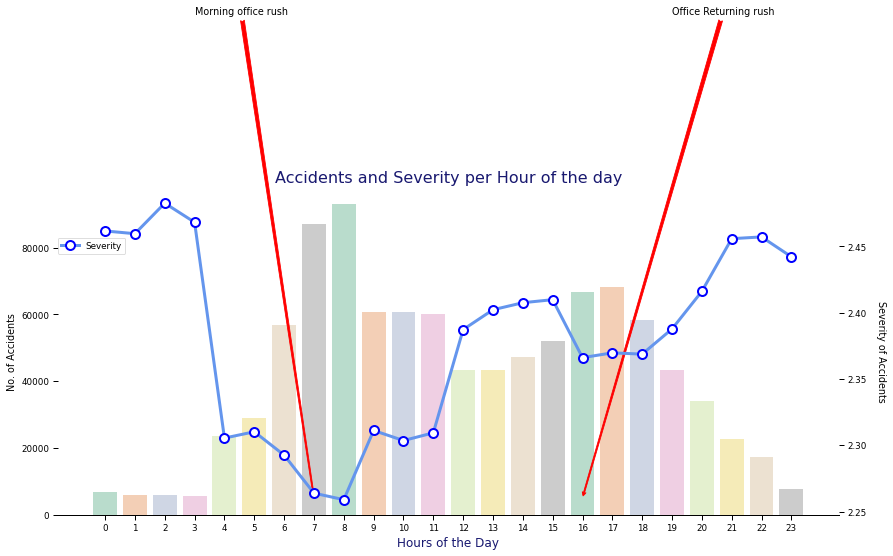

In [17]:
fig, ax = plt.subplots(1,1,figsize = (14,6))

sns.set_context('paper')

# ax.plot(hour_severity['Hour'], color='Salmon' , linewidth=3, linestyle='solid',
#         marker='*',markersize=18, markerfacecolor='w',markeredgecolor='m',markeredgewidth='2',
#         label = 'No. of Accidents'
#        )


f = sns.barplot(x=hour_severity['Hour'].index , y=hour_severity['Hour'], ax = ax, palette='Pastel2')

ax2 = ax.twinx()

ax2.plot(hour_severity['Severity'] , color='CornFlowerBlue', label='Severity',linewidth=3,
           linestyle='solid',marker='.',markersize=18, markerfacecolor='w',markeredgecolor='b',markeredgewidth='2')

sns.despine(left=True)
# ax.spines[('top')].set_visible(False)
# ax.spines[('right')].set_visible(False)
# ax.spines[('left')].set_visible(False)
ax2.spines[('top')].set_visible(False)
ax2.spines[('right')].set_visible(False)
ax2.spines[('left')].set_visible(False)
ax.set_xlabel("Hours of the Day", fontdict = {'fontsize':12 , 'color':'MidnightBlue'} )
ax.set_ylabel("No. of Accidents")
ax2.set_ylabel("Severity of Accidents", rotation=270 ,labelpad=20)
ax.set_title('Accidents and Severity per Hour of the day', fontdict = {'fontsize':16 , 'color':'MidnightBlue'})
# ax.legend(loc=(0,1))
ax2.legend(loc=(0,0.8))

ax.annotate('Morning office rush' , xytext=(3,150000) , xy=(7,5000),arrowprops={'arrowstyle':'fancy' , 'color':'Red'})
ax.annotate('Office Returning rush' , xytext=(19,150000),xy=(16,5000),arrowprops={'arrowstyle':'fancy', 'color':'Red'})

fig.show()

In [18]:
sev_4_mean = df[df['Severity'] == 4][['Severity','Year']].groupby('Year').count().mean()
sev_4_mean[0]

1237.5

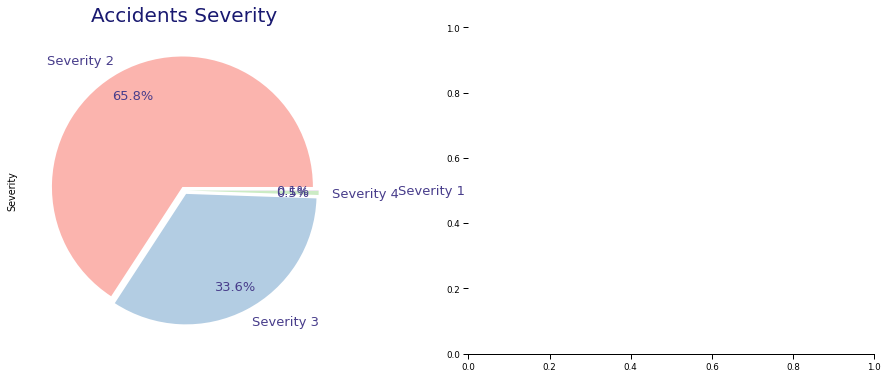

In [61]:
f , (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

df['Severity'].value_counts().plot.pie(autopct = '%1.1f%%' , ax=ax1, colors =sns.color_palette(palette='Pastel1') ,
                                      pctdistance = 0.8, explode = [.03,.03,.03,  .03], 
                                       textprops = {'fontsize' : 13 , 'color' : 'DarkSlateBlue'},
                                       labels=['Severity 2','Severity 3' , 'Severity 4' , '                Severity 1']
                              )

ax1.set_title("Accidents Severity", fontdict = {'fontsize':20 , 'color':'MidnightBlue'} )

sns.despine(left=True)

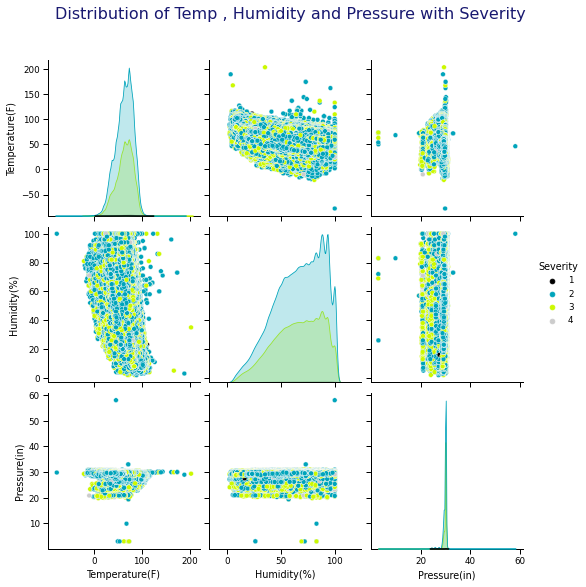

In [57]:
pair = sns.pairplot(df[['Severity','Temperature(F)','Humidity(%)','Pressure(in)']].dropna(), hue='Severity', palette='nipy_spectral')
# pair = sns.pairplot(df[['Severity','Temperature(F)']].dropna(), hue='Severity', palette='nipy_spectral')

pair.fig.suptitle('Distribution of Temp , Humidity and Pressure with Severity', y =1.08 
                  , fontsize = 16 , color = 'MidnightBlue' , ha = 'center' , va='top')

plt.show()

In [21]:
# Generalization of Weather condition

conditions = df['Weather_Condition'].dropna().unique().tolist()

condition_map = dict()


for x in conditions :
    if x.lower().find('snow')>0 or x.lower().startswith('snow') or x.lower().find('ice')>0 or x.lower().startswith('ice'):
        condition_map[x] = 'Snow Situation'
    elif (x.lower().find('rain')>0 or x.lower().find('drizzle')>0 or 
          x.lower().startswith('rain') or x.lower().startswith('drizzle') or
          x.lower().find('thunder')>0 or x.lower().startswith('thunder')):
        condition_map[x] = 'Rainy Situation'
    elif (x.lower().find('storm')>0 or x.lower().find('thunder')>0):
        condition_map[x] = 'Storm Situation'
    elif (x.lower().find('cloud')>0 or x.lower().startswith('cloud')>0):
        condition_map[x] = 'Cloudy'
    elif (x.lower().find('fog')>0 or x.lower().startswith('fog')>0):
        condition_map[x] = 'Fog'
    elif (x.lower().find('dust')>0 or x.lower().startswith('dust')>0):
        condition_map[x] = 'Dust'
    elif (x.lower().find('wind')>0 or x.lower().startswith('wind')>0):
        condition_map[x] = 'Windy'
    else:
        condition_map[x] =x


df['Weather'] = df['Weather_Condition'].map(condition_map)
# df['Weather'].value_counts().sort_values(ascending=False).head(20)
total = len(df['Weather'])
# total
top_10_weather = df['Weather'].value_counts()[:10]
top_15_weather = df['Weather'].value_counts()[:13]

top_10_weather
# condition_map

Cloudy             359011
Fair               210865
Clear              208889
Overcast            80264
Rainy Situation     77011
Snow Situation      12491
Fog                 12490
Haze                 9790
Storm Situation      2830
Smoke                2694
Name: Weather, dtype: int64

In [22]:
def check_exist(x):
    if x in top_15_weather :
        return x
    else :
        return 'Other'

df['Weather2'] = df['Weather'].apply(check_exist)

cmap = {x:y for (x,y) in zip(top_10_weather.index , sns.color_palette('pastel'))}

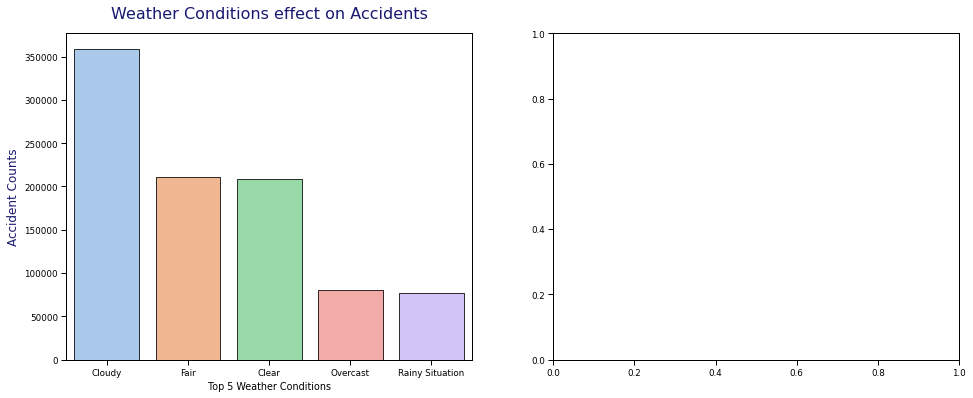

In [30]:
# Analysing the 'Weather_Condition' attribute

fig,(ax,ax2) = plt.subplots(1,2,figsize = (16, 6))

sns.countplot(x='Weather', data=df[['Weather','Severity']], order=df['Weather'].value_counts()[:5].index, 
              palette=cmap , edgecolor = 'black' , 
              ax= ax)


ax.set_ylabel("Accident Counts", fontdict = {'fontsize':12 , 'color':'MidnightBlue'} )
ax.set_xlabel("Top 5 Weather Conditions")
ax.set_title('Weather Conditions effect on Accidents', fontdict = {'fontsize':16 , 'color':'MidnightBlue'}, pad=15)

# ax.grid(axis='y', linestyle='-', alpha=0.4) 
#sns.despine(left=True)

plt.show()

In [63]:
df_nyc = df[df['City'] == 'New York']

year = df_nyc['Year'].value_counts()
month = df_nyc['Month'].value_counts().sort_index()
month_map = {1:'Jan' , 2:'Feb' , 3:'Mar' , 4:'Apr' , 5:'May' , 6:'Jun', 7:'Jul' , 8:'Aug' 
             , 9:'Sep',10:'Oct' , 11:'Nov' , 12:'Dec'}
hour = df_nyc['Hour'].value_counts().sort_index()

hour_severity = df_nyc[['Hour' , 'Severity']].groupby('Hour').agg({'Hour' : 'count' , 'Severity' : 'mean'})

# df_nyc['Day'] = df_nyc['Start_Time'].dt.dayofweek
day_severity = df_nyc['Day'].value_counts().sort_index()
# day_severity = df_nyc[['Day' , 'Severity']].groupby('Day').agg({'Day' : 'count' , 'Severity' : 'mean'})
day_map = {0:'Monday' , 1:'Tueday' , 2:'Wedday' , 3:"Thuday" , 4:'Friday' , 5:"Saturday" , 6:'Sunday'}
year_map = {x:x for x in year.index}
hour_map = {x:x for x in hour.index}

light_palette = sns.color_palette(palette='pastel')

In [64]:
day_severity = df_nyc['Day'].value_counts().sort_index()

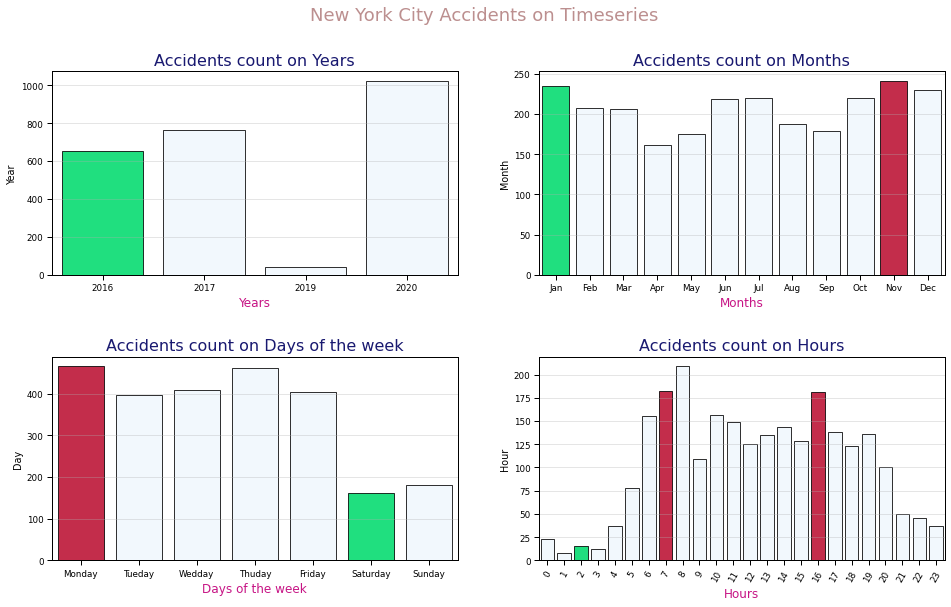

In [65]:
fig,([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2,figsize=(16,9))

def plot_dist(kind  , text ,axis,  red, green  ) :
    '''
    Reusable function to plot distribution based on input time criteria
    Usage : plot_dist(kind, text, axis, red , green) - all params mandatory
    
        kind : 'd' for day, 'm' for month , 'y' for year, 'h' for hour
        red  : list of item to be rendered red (max)
        green : list of item to be rendered green (min)
        text : Text to be showns as part of Title
        axis : Axis to plot on  
    '''
    if kind == 'd' :
        tot, ser, map = 7, day_severity ,  day_map
    elif kind == 'm':
        tot, ser, map = 12, month ,  month_map
    elif kind == 'y':
        tot, ser, map = 5, year ,  year_map
    elif kind == 'h':
        tot, ser, map = 24, hour ,  hour_map
    
    day_color_map = ['AliceBlue' for _ in range(tot)]
    for r in red:
        day_color_map[r] = 'Crimson' 
    for g in green:
        day_color_map[g] = 'SpringGreen' 
    
    d = sns.barplot(x=ser.index.map(map) , y=ser, ax = axis, palette = day_color_map, edgecolor='black' )
    plt.xticks(rotation=60)
    axis.set_xlabel(text, fontdict = {'fontsize':12 , 'color':'MediumVioletRed'} )
    axis.set_title(f'Accidents count on {text}', fontdict = {'fontsize':16 , 'color':'MidnightBlue'})
    axis.grid(axis='y', linestyle='-', alpha=0.4) 
    
plt.subplots_adjust(wspace=0.2 , hspace = 0.4)
plt.suptitle("New York City Accidents on Timeseries" , fontsize = 18 , color="RosyBrown")

plot_dist('d' ,"Days of the week", ax3,[0],[5])
plot_dist('y' ,"Years", ax1,[4],[0])
plot_dist('m' ,"Months", ax2, [10],[0])
plot_dist('h' ,"Hours", ax4,red=[7,16],green=[2])
plt.show()

In [66]:
top_st = df_nyc['Street'].value_counts().sort_values(ascending=False).head(10).index.tolist()

In [67]:
top_st_severity = df_nyc[df_nyc['Street'].isin(top_st)][['Street' , 'Severity']] .groupby('Street').mean()

top_st_delay = df_nyc[df_nyc['Street'].isin(top_st)][['Street' , 'DelayTime']] .groupby('Street').mean()

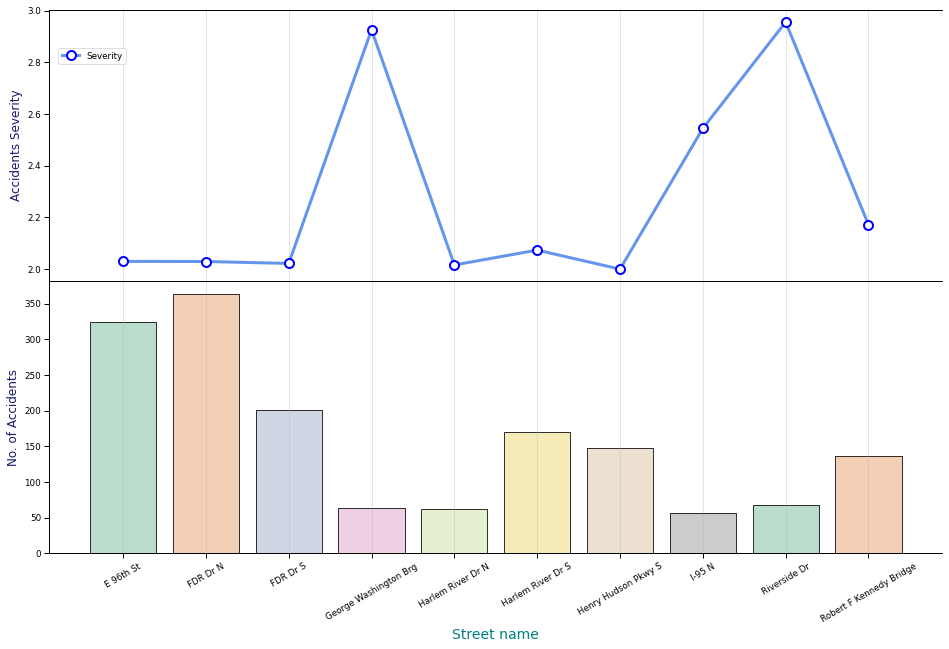

In [72]:
fig, (ax2,ax3) = plt.subplots(2,1,figsize=(16,10), sharex=True)

fig.subplots_adjust(hspace=0)

sns.countplot(data = df_nyc[df_nyc['Street'].isin(top_st)][['Street' , 'Severity']] ,
              x='Street' , ax=ax3, palette='Pastel2',edgecolor = 'Black')
plt.xticks(rotation=30)

ax2.plot( top_st_severity, color='CornFlowerBlue', label='Severity',linewidth=3,
           linestyle='solid',marker='.',markersize=18, markerfacecolor='w',markeredgecolor='b',markeredgewidth='2')


ax2.spines[('right')].set_visible(False)
ax3.spines[('right')].set_visible(False)
ax3.set_xlabel("Street name", fontdict = {'fontsize':14 , 'color':'Teal'} )
ax3.set_ylabel("No. of Accidents", fontdict = {'fontsize':12 , 'color':'MidnightBlue'})
ax2.set_ylabel("Accidents Severity", fontdict = {'fontsize':12 , 'color':'MidnightBlue'})
ax2.legend(loc=(0.01,0.8))
ax2.grid(axis='x', linestyle='-', alpha=0.4) 
ax3.grid(axis='x', linestyle='-', alpha=0.4) 

plt.show()

In [73]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True)

In [75]:
fig = go.Figure(
    data=go.Choropleth(
        locations = pd.value_counts(df['State']).index, 
        z = pd.value_counts(df['State']).values.astype(float), 
        locationmode = 'USA-states', 
        colorscale = 'reds', 
        colorbar_title = " Accident Counts"), 
    
    layout=go.Layout(
        title_text='Accidents Counts by States', 
        title_x=0.5, 
        font=dict(family='Calibri', size=14, color='MidnightBlue'), 
        geo_scope='usa'))

fig.show()